## Recomposição MLP


In [2]:
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from pathlib import Path

def criar_dataset_mlp(series, look_back=10, passo=1):
    """
    Dataset para MLP - cria janelas deslizantes para entrada sequencial
    """
    X, y = [], []
    for i in range(len(series) - look_back - passo + 1):
        sequencia = series[i:i+look_back].flatten()  # Flatten para MLP
        target = series[i+look_back+passo-1]
        X.append(sequencia)
        y.append(target[0] if hasattr(target, '__len__') else target)
    return np.array(X), np.array(y)

def calcular_metricas(y_true, y_pred):
    """Calcular métricas de avaliação"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100
    c30 = np.sum((y_pred >= 0.7 * y_true) & (y_pred <= 1.3 * y_true)) / len(y_true) * 100
    
    # Métricas adicionais
    r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    
    return {
        'RMSE': rmse,
        'MAE': mae, 
        'MAPE': mape,
        'C30': c30,
        'R2': r2
    }

def obter_look_back_correto(passo):
    """
    Retorna o look_back correto baseado no passo de previsão
    - t+1 e t+5: look_back = 5
    - demais: look_back = 10
    """
    if passo in [1, 5]:
        return 5
    else:
        return 10

def prever_componente_mlp(nome_comp, passo):
    """
    Previsão com MLP para qualquer componente (A3, D1, D2, D3)
    """
    print(f"   🧠 Prevendo {nome_comp.upper()} com MLP...")
    
    # Look_back baseado na regra
    look_back_mlp = obter_look_back_correto(passo)
    
    # Carregar dados
    serie_path = Path(f"{nome_comp.upper()}_component.csv")
    if not serie_path.exists():
        raise FileNotFoundError(f"Arquivo {serie_path} não encontrado")
    
    serie = pd.read_csv(serie_path)[nome_comp.upper()].values.reshape(-1, 1)
    
    # Carregar scaler
    scaler_path = Path(f"scalersMLP/scaler_{nome_comp.lower()}_t{passo}.joblib")
    if not scaler_path.exists():
        raise FileNotFoundError(f"Scaler {scaler_path} não encontrado")
    
    scaler = joblib.load(scaler_path)
    serie_scaled = scaler.transform(serie)
    
    print(f"      - Scaler: {type(scaler).__name__}")
    print(f"      - Look_back: {look_back_mlp}")
    
    # Criar dataset para MLP
    X, _ = criar_dataset_mlp(serie_scaled, look_back_mlp, passo)
    
    print(f"      - Dataset shape: {X.shape}")
    
    # Carregar modelo MLP
    modelo_path = Path(f"modelosMLP/mlp_{nome_comp.lower()}_t{passo}.keras")
    if not modelo_path.exists():
        raise FileNotFoundError(f"Modelo {modelo_path} não encontrado")
    
    modelo = load_model(modelo_path)
    
    # Verificar compatibilidade
    input_shape_esperado = modelo.input_shape[1]
    if X.shape[1] == input_shape_esperado:
        print(f"      ✅ Compatível: {X.shape[1]} features")
    else:
        raise ValueError(f"Incompatibilidade: Dataset={X.shape[1]} vs Modelo={input_shape_esperado}")
    
    # Fazer previsão
    y_pred_scaled = modelo.predict(X, verbose=0).flatten()
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    
    print(f"      ✅ Previsão: {len(y_pred)} pontos, range=[{y_pred.min():.3f}, {y_pred.max():.3f}], std={np.std(y_pred):.4f}")
    
    return y_pred

def otimizar_pesos_componentes_original(y_real_original, componentes_pred, passo):
    """
    Otimização de pesos na ESCALA ORIGINAL (sem normalização)
    """
    from sklearn.linear_model import Ridge
    from sklearn.metrics import r2_score
    
    print(f"   🎯 Otimizando pesos na escala original...")
    
    # Garantir mesmo tamanho
    min_len = min(len(y_real_original), *[len(comp) for comp in componentes_pred])
    
    # Matriz de componentes (escala original)
    X_componentes = np.column_stack([comp[:min_len] for comp in componentes_pred])
    y_target = y_real_original[:min_len]
    
    # Ridge regression
    reg = Ridge(alpha=0.1, fit_intercept=False)
    reg.fit(X_componentes, y_target)
    
    pesos_otimizados = reg.coef_
    r2 = r2_score(y_target, reg.predict(X_componentes))
    
    # Log dos pesos
    nomes_comp = ['A3', 'D1', 'D2', 'D3']
    for nome, peso in zip(nomes_comp, pesos_otimizados):
        print(f"      - Peso {nome}: {peso:.4f}")
    
    print(f"      - R² da otimização: {r2:.4f}")
    
    # Salvar configuração
    pesos_config = {
        'passo': passo,
        'pesos': {nome: float(peso) for nome, peso in zip(nomes_comp, pesos_otimizados)},
        'r2_score': float(r2),
        'metodo': 'Ridge_escala_original_MLP'
    }
    
    os.makedirs("pesosMLP", exist_ok=True)
    with open(f"pesosMLP/pesos_originais_t{passo}.json", 'w') as f:
        json.dump(pesos_config, f, indent=2)
    
    return pesos_otimizados

def carregar_pesos_otimizados_mlp(passo):
    """Carrega pesos otimizados se existirem (específicos para MLP)"""
    
    # Tentar carregar pesos específicos para MLP
    config_path = Path(f"pesosMLP/pesos_originais_t{passo}.json")
    
    try:
        if config_path.exists():
            with open(config_path, 'r') as f:
                config = json.load(f)
            
            pesos = [config['pesos']['A3'], config['pesos']['D1'], 
                    config['pesos']['D2'], config['pesos']['D3']]
            r2 = config.get('r2_score', 0)
            
            print(f"   📊 Pesos MLP carregados (R²={r2:.3f})")
            return np.array(pesos)
    except Exception as e:
        print(f"   ⚠️ Erro ao carregar pesos MLP: {e}")
    
    # Pesos padrão
    print(f"   📊 Usando pesos padrão (soma simples)")
    return np.array([1.0, 1.0, 1.0, 1.0])

def aplicar_filtros_pos_processamento(y_pred, metodo='suavizacao', janela=3):
    """
    Aplica filtros de pós-processamento para suavizar previsões
    """
    try:
        if metodo == 'suavizacao':
            # Média móvel simples usando pandas
            df_temp = pd.DataFrame({'values': y_pred})
            y_filtrado = df_temp['values'].rolling(window=janela, center=True, min_periods=1).mean().values
            return y_filtrado
        
        elif metodo == 'mediana':
            # Filtro de mediana manual
            y_filtrado = np.copy(y_pred)
            half_window = janela // 2
            
            for i in range(len(y_pred)):
                start_idx = max(0, i - half_window)
                end_idx = min(len(y_pred), i + half_window + 1)
                y_filtrado[i] = np.median(y_pred[start_idx:end_idx])
            
            return y_filtrado
    except:
        pass
    
    return y_pred

def recompor_e_avaliar_mlp(passo, otimizar_pesos=True, usar_pesos_salvos=True, aplicar_filtro=True):
    """
    SISTEMA MLP COMPLETO - Avaliação da recomposição
    Todos os componentes (A3, D1, D2, D3) usando MLP
    """
    look_back_mlp = obter_look_back_correto(passo)
    
    print(f"\n🚀 SISTEMA MLP COMPLETO - Avaliação t+{passo}")
    print(f"   🧠 A3, D1, D2, D3: MLP (redes neurais densas) - look_back={look_back_mlp}")
    
    try:
        # ==============================================
        # 1. CARREGAR DADOS REAIS
        # ==============================================
        df_path = Path("RMDM_corrigido.csv")
        if not df_path.exists():
            raise FileNotFoundError("❌ Arquivo RMDM_corrigido.csv não encontrado")
        
        df = pd.read_csv(df_path)
        rmdm_real = df["RMDM"].values
        
        # Normalização dos dados reais
        scaler_rmdm = MinMaxScaler()
        rmdm_real_norm = scaler_rmdm.fit_transform(rmdm_real.reshape(-1, 1)).flatten()
        print(f"   📏 Dados reais: {len(rmdm_real)} pontos")

        # ==============================================
        # 2. MLP PARA TODOS OS COMPONENTES
        # ==============================================
        print(f"\n   🧠 Processando TODOS os componentes com MLP...")
        componentes_pred = {}
        
        for comp in ['a3', 'd1', 'd2', 'd3']:
            try:
                componentes_pred[comp] = prever_componente_mlp(comp, passo)
            except Exception as e:
                print(f"      ❌ Erro em {comp.upper()}: {e}")
                raise

        # Aplicar clipping muito suave
        limite_clip = 20.0
        print(f"\n   🔧 Aplicando clipping suave (limite ±{limite_clip})...")
        for comp in componentes_pred:
            original_range = [componentes_pred[comp].min(), componentes_pred[comp].max()]
            componentes_pred[comp] = np.clip(componentes_pred[comp], -limite_clip, limite_clip)
            clipped_range = [componentes_pred[comp].min(), componentes_pred[comp].max()]
            print(f"      - {comp.upper()}: {original_range[0]:.3f}~{original_range[1]:.3f} → {clipped_range[0]:.3f}~{clipped_range[1]:.3f}")

        # Aplicar filtros de pós-processamento
        if aplicar_filtro:
            print(f"\n   🔧 Aplicando filtros de pós-processamento...")
            for comp in componentes_pred:
                original_std = np.std(componentes_pred[comp])
                componentes_pred[comp] = aplicar_filtros_pos_processamento(
                    componentes_pred[comp], 
                    metodo='suavizacao', 
                    janela=3
                )
                filtrado_std = np.std(componentes_pred[comp])
                print(f"      - {comp.upper()}: std {original_std:.4f} → {filtrado_std:.4f}")

        # ==============================================
        # 3. VERIFICAÇÃO DE RECONSTRUÇÃO WAVELET
        # ==============================================
        print(f"\n   🔍 VERIFICANDO RECONSTRUÇÃO WAVELET...")
        
        # Carregar componentes originais para teste
        df_a3_orig = pd.read_csv("A3_component.csv")
        df_d1_orig = pd.read_csv("D1_component.csv") 
        df_d2_orig = pd.read_csv("D2_component.csv")
        df_d3_orig = pd.read_csv("D3_component.csv")
        
        a3_orig = df_a3_orig["A3"].values
        d1_orig = df_d1_orig["D1"].values
        d2_orig = df_d2_orig["D2"].values
        d3_orig = df_d3_orig["D3"].values
        
        # Verificar se componentes originais recompõem o sinal
        min_len_orig = min(len(a3_orig), len(d1_orig), len(d2_orig), len(d3_orig), len(rmdm_real))
        
        soma_componentes_orig = (a3_orig[:min_len_orig] + d1_orig[:min_len_orig] + 
                                d2_orig[:min_len_orig] + d3_orig[:min_len_orig])
        
        erro_reconstrucao = np.mean(np.abs(rmdm_real[:min_len_orig] - soma_componentes_orig))
        print(f"      - Erro de reconstrução original: {erro_reconstrucao:.6f}")
        
        if erro_reconstrucao > 0.001:
            print(f"      ⚠️ ALERTA: Componentes originais não recompõem perfeitamente o sinal!")
        else:
            print(f"      ✅ Componentes originais recompõem o sinal corretamente")

        # ==============================================
        # 4. ALINHAMENTO E CONFIGURAÇÃO DE PESOS
        # ==============================================
        print(f"\n   ⚖️ Configurando pesos de recomposição...")
        
        # Determinar tamanhos para alinhamento
        todos_componentes = list(componentes_pred.values())
        min_len = min(len(comp) for comp in todos_componentes)
        
        # Calcular índice inicial
        indice_inicial = look_back_mlp + passo - 1
        
        print(f"      - Look_back MLP: {look_back_mlp}")
        print(f"      - Tamanhos: min_len={min_len}, índice_inicial={indice_inicial}")

        # Ajustar dados reais (SEM normalização)
        if indice_inicial + min_len > len(rmdm_real):
            min_len = len(rmdm_real) - indice_inicial
        
        if min_len <= 0:
            raise ValueError("❌ Dados insuficientes após alinhamento")
        
        y_real_original = rmdm_real[indice_inicial:indice_inicial + min_len]
        print(f"      ✅ Dados alinhados: {len(y_real_original)} pontos (escala original)")

        if usar_pesos_salvos:
            pesos = carregar_pesos_otimizados_mlp(passo)
        else:
            pesos = np.array([1.0, 1.0, 1.0, 1.0])
        
        if otimizar_pesos and not usar_pesos_salvos:
            # Otimizar pesos na ESCALA ORIGINAL
            componentes_para_otim = [
                componentes_pred['a3'][:min_len],
                componentes_pred['d1'][:min_len],
                componentes_pred['d2'][:min_len], 
                componentes_pred['d3'][:min_len]
            ]
            
            # Usar os dados reais na escala original para otimização
            pesos = otimizar_pesos_componentes_original(y_real_original, componentes_para_otim, passo)

        # ==============================================
        # 5. RECOMPOSIÇÃO FINAL NA ESCALA ORIGINAL
        # ==============================================
        print(f"\n   🔀 Recompondo sinal final (escala original)...")
        print(f"      - Usando pesos: A3={pesos[0]:.3f}, D1={pesos[1]:.3f}, D2={pesos[2]:.3f}, D3={pesos[3]:.3f}")
        
        # Mostrar estatísticas dos componentes antes da soma
        print(f"   📊 Estatísticas dos componentes (escala original):")
        print(f"      - A3:  range=[{componentes_pred['a3'][:min_len].min():.3f}, {componentes_pred['a3'][:min_len].max():.3f}], std={np.std(componentes_pred['a3'][:min_len]):.3f}")
        print(f"      - D1:  range=[{componentes_pred['d1'][:min_len].min():.3f}, {componentes_pred['d1'][:min_len].max():.3f}], std={np.std(componentes_pred['d1'][:min_len]):.3f}")
        print(f"      - D2:  range=[{componentes_pred['d2'][:min_len].min():.3f}, {componentes_pred['d2'][:min_len].max():.3f}], std={np.std(componentes_pred['d2'][:min_len]):.3f}")
        print(f"      - D3:  range=[{componentes_pred['d3'][:min_len].min():.3f}, {componentes_pred['d3'][:min_len].max():.3f}], std={np.std(componentes_pred['d3'][:min_len]):.3f}")
        
        # Recomposição DIRETA na escala original (como wavelet)
        y_final = (
            pesos[0] * componentes_pred['a3'][:min_len] +
            pesos[1] * componentes_pred['d1'][:min_len] +
            pesos[2] * componentes_pred['d2'][:min_len] +
            pesos[3] * componentes_pred['d3'][:min_len]
        )
        
        print(f"   📊 Após recomposição (escala original):")
        print(f"      - Range: [{y_final.min():.3f}, {y_final.max():.3f}]")
        print(f"      - Std: {np.std(y_final):.3f}")

        # Dados reais para comparação
        y_real = y_real_original

        # Garantir mesmo tamanho final
        min_compare_len = min(len(y_real), len(y_final))
        y_real = y_real[:min_compare_len]
        y_final = y_final[:min_compare_len]
        
        print(f"      ✅ Recomposição: {min_compare_len} pontos")
        print(f"      - Range real: [{y_real.min():.3f}, {y_real.max():.3f}]")
        print(f"      - Range previsto: [{y_final.min():.3f}, {y_final.max():.3f}]")

        # ==============================================
        # 6. CÁLCULO DE MÉTRICAS
        # ==============================================
        print(f"\n   📊 Calculando métricas...")
        metricas = calcular_metricas(y_real, y_final)
        
        print(f"✅ MÉTRICAS FINAIS MLP t+{passo}:")
        print(f"   🎯 RMSE: {metricas['RMSE']:.4f}")
        print(f"   🎯 MAE:  {metricas['MAE']:.4f}")
        print(f"   🎯 MAPE: {metricas['MAPE']:.2f}%")
        print(f"   🎯 C30:  {metricas['C30']:.2f}%")
        print(f"   🎯 R²:   {metricas['R2']:.4f}")

        # ==============================================
        # 7. COMPARAÇÃO COM SOMA SIMPLES
        # ==============================================
        if not np.allclose(pesos, [1.0, 1.0, 1.0, 1.0], rtol=1e-3):
            print(f"\n   📊 Comparando com soma simples...")
            y_final_simples = (
                componentes_pred['a3'][:min_len] + 
                componentes_pred['d1'][:min_len] + 
                componentes_pred['d2'][:min_len] + 
                componentes_pred['d3'][:min_len]
            )
            y_final_simples = y_final_simples[:min_compare_len]
            
            metricas_simples = calcular_metricas(y_real, y_final_simples)
            
            print(f"   📊 Soma simples: RMSE={metricas_simples['RMSE']:.4f}, MAE={metricas_simples['MAE']:.4f}")
            
            melhoria_rmse = ((metricas_simples['RMSE'] - metricas['RMSE']) / metricas_simples['RMSE']) * 100
            melhoria_mae = ((metricas_simples['MAE'] - metricas['MAE']) / metricas_simples['MAE']) * 100
            
            print(f"   🎯 Melhoria: RMSE {melhoria_rmse:+.2f}%, MAE {melhoria_mae:+.2f}%")

        # ==============================================
        # 8. VISUALIZAÇÃO COMPLETA
        # ==============================================
        print(f"\n   📈 Gerando visualizações completas...")
        
        plt.figure(figsize=(20, 16))
        
        # 1. Série temporal principal
        plt.subplot(4, 2, 1)
        plt.plot(y_real, label="RMDM Real", color='blue', linewidth=2, alpha=0.8)
        plt.plot(y_final, label=f"Previsto MLP t+{passo}", color='red', linestyle='--', linewidth=2)
        plt.title(f"SISTEMA MLP COMPLETO (t+{passo}) - RMSE: {metricas['RMSE']:.4f}")
        plt.xlabel("Tempo")
        plt.ylabel("Velocidade do Vento [m/s]")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. Zoom nos primeiros pontos
        plt.subplot(4, 2, 2)
        n_zoom = min(200, len(y_real))
        plt.plot(y_real[:n_zoom], label="Real", color='blue', linewidth=2)
        plt.plot(y_final[:n_zoom], label="Previsto", color='red', linestyle='--', linewidth=2)
        plt.title(f"Zoom - Primeiros {n_zoom} pontos")
        plt.xlabel("Tempo")
        plt.ylabel("Velocidade do Vento [m/s]")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. Análise de erro
        plt.subplot(4, 2, 3)
        erro = y_real - y_final
        plt.plot(erro, label="Erro", color='green', alpha=0.7)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.axhline(y=np.mean(erro), color='red', linestyle='--', alpha=0.5, label=f'Média: {np.mean(erro):.4f}')
        plt.axhline(y=np.std(erro), color='orange', linestyle=':', alpha=0.5, label=f'±Std: {np.std(erro):.4f}')
        plt.axhline(y=-np.std(erro), color='orange', linestyle=':', alpha=0.5)
        plt.title(f"Erro de Previsão (MAE: {metricas['MAE']:.4f})")
        plt.xlabel("Tempo")
        plt.ylabel("Erro [m/s]")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 4. Dispersão com bandas
        plt.subplot(4, 2, 4)
        plt.scatter(y_real, y_final, alpha=0.6, color='purple', s=20, edgecolors='black', linewidth=0.1)
        
        min_val, max_val = min(y_real.min(), y_final.min()), max(y_real.max(), y_final.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2, label='Perfeita')
        
        x_linha = np.linspace(min_val, max_val, 100)
        plt.fill_between(x_linha, 0.9*x_linha, 1.1*x_linha, alpha=0.2, color='green', label='±10%')
        plt.fill_between(x_linha, 0.8*x_linha, 1.2*x_linha, alpha=0.1, color='yellow', label='±20%')
        
        plt.xlabel("RMDM Real [m/s]")
        plt.ylabel("RMDM Previsto [m/s]")
        plt.title(f"Dispersão (R² = {metricas['R2']:.4f})")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 5. Histograma dos erros
        plt.subplot(4, 2, 5)
        plt.hist(erro, bins=50, alpha=0.7, color='green', edgecolor='black', density=True)
        plt.axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Zero')
        plt.axvline(x=np.mean(erro), color='orange', linestyle='--', alpha=0.8, label=f'Média: {np.mean(erro):.3f}')
        plt.xlabel("Erro [m/s]")
        plt.ylabel("Densidade")
        plt.title("Distribuição dos Erros")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 6. Componentes individuais
        plt.subplot(4, 2, 6)
        n_comp_plot = min(100, min_compare_len)
        
        plt.plot(componentes_pred['a3'][:n_comp_plot], label='A3 (MLP)', color='blue', alpha=0.7, linewidth=1.5)
        plt.plot(componentes_pred['d1'][:n_comp_plot], label='D1 (MLP)', color='red', alpha=0.7, linewidth=1.5)
        plt.plot(componentes_pred['d2'][:n_comp_plot], label='D2 (MLP)', color='green', alpha=0.7, linewidth=1.5)
        plt.plot(componentes_pred['d3'][:n_comp_plot], label='D3 (MLP)', color='orange', alpha=0.7, linewidth=1.5)
        
        plt.title("Componentes Individuais (MLP)")
        plt.xlabel("Tempo")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 7. MAE por faixas de velocidade
        plt.subplot(4, 2, 7)
        faixas = [(0, 5), (5, 10), (10, 15), (15, 20), (20, 30)]
        mae_faixas = []
        n_pontos_faixas = []
        
        for baixo, alto in faixas:
            mask = (y_real >= baixo) & (y_real < alto)
            if np.sum(mask) > 0:
                mae_faixa = np.mean(np.abs(y_real[mask] - y_final[mask]))
                mae_faixas.append(mae_faixa)
                n_pontos_faixas.append(np.sum(mask))
            else:
                mae_faixas.append(0)
                n_pontos_faixas.append(0)
        
        faixas_str = [f"{b}-{a}\n({n})" for (b, a), n in zip(faixas, n_pontos_faixas)]
        
        bars = plt.bar(range(len(faixas)), mae_faixas, alpha=0.7, 
                      color=['lightblue', 'lightgreen', 'lightyellow', 'orange', 'lightcoral'])
        plt.xticks(range(len(faixas)), faixas_str)
        plt.ylabel("MAE [m/s]")
        plt.title("MAE por Faixa de Velocidade")
        plt.grid(True, alpha=0.3)
        
        for bar, mae in zip(bars, mae_faixas):
            if mae > 0:
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                        f'{mae:.3f}', ha='center', va='bottom', fontsize=8)
        
        # 8. Box plot comparativo
        plt.subplot(4, 2, 8)
        dados_box = [y_real, y_final, erro]
        labels_box = ['Real', 'Previsto', 'Erro']
        
        box_plot = plt.boxplot(dados_box, labels=labels_box, patch_artist=True)
        cores_box = ['lightblue', 'lightcoral', 'lightgreen']
        for patch, cor in zip(box_plot['boxes'], cores_box):
            patch.set_facecolor(cor)
        
        plt.title("Distribuição Comparativa")
        plt.ylabel("Velocidade do Vento [m/s]")
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # ==============================================
        # 9. ANÁLISE ESTATÍSTICA DETALHADA
        # ==============================================
        print(f"\n   📊 ANÁLISE ESTATÍSTICA DETALHADA:")
        print(f"   " + "="*50)
        
        print(f"   📈 DADOS REAIS:")
        print(f"      Min: {y_real.min():.3f} | Max: {y_real.max():.3f}")
        print(f"      Média: {np.mean(y_real):.3f} | Std: {np.std(y_real):.3f}")
        print(f"      Q25: {np.percentile(y_real, 25):.3f} | Q75: {np.percentile(y_real, 75):.3f}")
        
        print(f"   🎯 PREVISÕES:")
        print(f"      Min: {y_final.min():.3f} | Max: {y_final.max():.3f}")
        print(f"      Média: {np.mean(y_final):.3f} | Std: {np.std(y_final):.3f}")
        print(f"      Q25: {np.percentile(y_final, 25):.3f} | Q75: {np.percentile(y_final, 75):.3f}")
        
        print(f"   ❌ ERROS:")
        print(f"      Erro médio: {np.mean(erro):.4f}")
        print(f"      Std erro: {np.std(erro):.4f}")
        print(f"      Max erro absoluto: {np.max(np.abs(erro)):.4f}")
        
        # Correlação
        correlacao = np.corrcoef(y_real, y_final)[0, 1]
        print(f"   🔗 CORRELAÇÃO: {correlacao:.4f}")
        
        # Análise de tendência
        bias = np.mean(erro)
        if abs(bias) < 0.1:
            bias_desc = "sem viés significativo"
        elif bias > 0:
            bias_desc = f"superestimação ({bias:.3f})"
        else:
            bias_desc = f"subestimação ({bias:.3f})"
        
        print(f"   ⚖️ TENDÊNCIA: {bias_desc}")
        
        return {f"t+{passo}": metricas}
        
    except Exception as e:
        print(f"❌ ERRO na avaliação MLP t+{passo}: {e}")
        import traceback
        print("📋 Detalhes do erro:")
        traceback.print_exc()
        return {f"t+{passo}": {"RMSE": None, "MAE": None, "MAPE": None, "C30": None, "R2": None}}

def avaliar_sistema_completo_mlp(passos=[1, 5, 7, 30], otimizar_pesos=True, aplicar_filtro=True):
    """
    Avaliação completa do sistema MLP para todos os componentes
    """
    print("🚀 SISTEMA MLP COMPLETO")
    print("=" * 70)
    print(f"🧠 A3, D1, D2, D3: MLP (Multi-Layer Perceptron)")
    print(f"📋 Horizontes de previsão: {passos}")
    print(f"🎯 Otimizar pesos: {'Sim' if otimizar_pesos else 'Não'}")
    print(f"🔧 Aplicar filtros: {'Sim' if aplicar_filtro else 'Não'}")
    print("=" * 70)
    
    resultados = {}
    resultados_detalhados = []
    
    for i, passo in enumerate(passos):
        print(f"\n{'🔵' * (i+1)} {'⚪' * (len(passos)-i-1)} PROCESSANDO t+{passo} ({i+1}/{len(passos)})")
        print("=" * 50)
        
        try:
            resultado = recompor_e_avaliar_mlp(
                passo, 
                otimizar_pesos=otimizar_pesos,
                usar_pesos_salvos=True,
                aplicar_filtro=aplicar_filtro
            )
            resultados.update(resultado)
            
            # Adicionar detalhes para análise
            if f"t+{passo}" in resultado and resultado[f"t+{passo}"]["RMSE"] is not None:
                resultado_detalhado = resultado[f"t+{passo}"].copy()
                resultado_detalhado['passo'] = passo
                resultado_detalhado['look_back'] = obter_look_back_correto(passo)
                resultado_detalhado['modelo'] = 'MLP_Completo'
                resultado_detalhado['arquitetura'] = 'Todos_componentes_MLP'
                resultados_detalhados.append(resultado_detalhado)
            
            print(f"✅ t+{passo} CONCLUÍDO")
            
        except Exception as e:
            print(f"❌ ERRO em t+{passo}: {e}")
            resultados[f"t+{passo}"] = {
                "RMSE": None, "MAE": None, "MAPE": None, "C30": None, "R2": None
            }
    
    # Tabela final de resultados
    print(f"\n{'=' * 70}")
    print("📊 TABELA FINAL DE MÉTRICAS - SISTEMA MLP COMPLETO")
    print("=" * 70)
    
    df_resultados = pd.DataFrame(resultados).T
    pd.set_option('display.float_format', '{:.4f}'.format)
    print(df_resultados)
    
    # Análise estatística
    if resultados_detalhados:
        print(f"\n📈 ANÁLISE ESTATÍSTICA:")
        print("-" * 40)
        
        df_analise = pd.DataFrame(resultados_detalhados)
        
        # Estatísticas por métrica
        metricas_interesse = ['RMSE', 'MAE', 'MAPE', 'C30', 'R2']
        for metrica in metricas_interesse:
            if metrica in df_analise.columns:
                valores = df_analise[metrica].dropna()
                if len(valores) > 0:
                    print(f"{metrica:>5}: min={valores.min():.4f}, max={valores.max():.4f}, média={valores.mean():.4f}")
        
        # Análise por look_back
        print(f"\n📏 ANÁLISE POR LOOK_BACK:")
        print("-" * 40)
        for lb in [5, 10]:
            subset = df_analise[df_analise['look_back'] == lb]
            if len(subset) > 0:
                passos_lb = subset['passo'].tolist()
                rmse_medio = subset['RMSE'].mean() if 'RMSE' in subset.columns else 'N/A'
                mae_medio = subset['MAE'].mean() if 'MAE' in subset.columns else 'N/A'
                print(f"Look_back {lb} (passos {passos_lb}):")
                print(f"   RMSE médio: {rmse_medio:.4f}" if rmse_medio != 'N/A' else "   RMSE: N/A")
                print(f"   MAE médio: {mae_medio:.4f}" if mae_medio != 'N/A' else "   MAE: N/A")
    
    # Visualização comparativa
    if len(resultados_detalhados) > 1:
        print(f"\n📊 Gerando gráfico comparativo...")
        
        plt.figure(figsize=(15, 10))
        
        passos_graf = [r['passo'] for r in resultados_detalhados]
        rmse_vals = [r['RMSE'] for r in resultados_detalhados]
        mae_vals = [r['MAE'] for r in resultados_detalhados]
        r2_vals = [r['R2'] for r in resultados_detalhados]
        
        # RMSE por horizonte
        plt.subplot(2, 2, 1)
        plt.plot(passos_graf, rmse_vals, 'bo-', linewidth=2, markersize=8)
        plt.xlabel('Horizonte de Previsão')
        plt.ylabel('RMSE')
        plt.title('RMSE por Horizonte (MLP)')
        plt.grid(True, alpha=0.3)
        plt.xticks(passos_graf)
        for x, y in zip(passos_graf, rmse_vals):
            plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        
        # MAE por horizonte
        plt.subplot(2, 2, 2)
        plt.plot(passos_graf, mae_vals, 'ro-', linewidth=2, markersize=8)
        plt.xlabel('Horizonte de Previsão')
        plt.ylabel('MAE')
        plt.title('MAE por Horizonte (MLP)')
        plt.grid(True, alpha=0.3)
        plt.xticks(passos_graf)
        for x, y in zip(passos_graf, mae_vals):
            plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        
        # R² por horizonte
        plt.subplot(2, 2, 3)
        plt.plot(passos_graf, r2_vals, 'go-', linewidth=2, markersize=8)
        plt.xlabel('Horizonte de Previsão')
        plt.ylabel('R²')
        plt.title('R² por Horizonte (MLP)')
        plt.grid(True, alpha=0.3)
        plt.xticks(passos_graf)
        for x, y in zip(passos_graf, r2_vals):
            plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        
        # Comparativo normalizado
        plt.subplot(2, 2, 4)
        rmse_norm = np.array(rmse_vals) / max(rmse_vals) if max(rmse_vals) > 0 else np.array(rmse_vals)
        mae_norm = np.array(mae_vals) / max(mae_vals) if max(mae_vals) > 0 else np.array(mae_vals)
        r2_norm = np.array(r2_vals) / max(r2_vals) if max(r2_vals) > 0 else np.array(r2_vals)
        
        x_pos = np.arange(len(passos_graf))
        width = 0.25
        
        plt.bar(x_pos - width, rmse_norm, width, label='RMSE', alpha=0.7)
        plt.bar(x_pos, mae_norm, width, label='MAE', alpha=0.7)
        plt.bar(x_pos + width, r2_norm, width, label='R²', alpha=0.7)
        
        plt.xlabel('Horizonte de Previsão')
        plt.ylabel('Métricas Normalizadas')
        plt.title('Comparativo de Métricas (MLP)')
        plt.xticks(x_pos, [f't+{p}' for p in passos_graf])
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Salvar resultados
    print(f"\n💾 SALVANDO RESULTADOS...")
    os.makedirs("resultados", exist_ok=True)
    
    arquivo_csv = "resultados/metricas_mlp_completo.csv"
    df_resultados.to_csv(arquivo_csv)
    print(f"   ✅ Métricas salvas: {arquivo_csv}")
    
    if resultados_detalhados:
        arquivo_analise = "resultados/analise_detalhada_mlp_completo.csv"
        pd.DataFrame(resultados_detalhados).to_csv(arquivo_analise, index=False)
        print(f"   ✅ Análise detalhada: {arquivo_analise}")
    
    resumo = {
        'data_avaliacao': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'sistema': 'MLP Completo',
        'descricao': 'Todos os componentes (A3, D1, D2, D3) usando MLP',
        'passos_avaliados': passos,
        'configuracao': {
            'otimizar_pesos': otimizar_pesos,
            'aplicar_filtro': aplicar_filtro,
            'arquitetura': 'Multi-Layer Perceptron',
            'entrada': 'Sequências temporais'
        },
        'resultados': resultados
    }
    
    arquivo_json = "resultados/resumo_mlp_completo.json"
    with open(arquivo_json, 'w', encoding='utf-8') as f:
        json.dump(resumo, f, indent=2, ensure_ascii=False)
    print(f"   ✅ Resumo JSON: {arquivo_json}")
    
    print(f"\n🎉 AVALIAÇÃO COMPLETA!")
    
    return resultados

def avaliar_passo_unico_mlp(passo, mostrar_detalhes=True):
    """
    Avalia um único passo de previsão com sistema MLP completo
    """
    print(f"🎯 Avaliação MLP COMPLETO para t+{passo}")
    print("-" * 40)
    
    resultado = recompor_e_avaliar_mlp(passo, otimizar_pesos=True, usar_pesos_salvos=True)
    
    if mostrar_detalhes and f"t+{passo}" in resultado:
        metricas = resultado[f"t+{passo}"]
        if metricas["RMSE"] is not None:
            print(f"\n📊 RESUMO MLP t+{passo}:")
            print(f"   RMSE: {metricas['RMSE']:.4f}")
            print(f"   MAE:  {metricas['MAE']:.4f}")
            print(f"   MAPE: {metricas['MAPE']:.2f}%")
            print(f"   C30:  {metricas['C30']:.2f}%")
            print(f"   R²:   {metricas['R2']:.4f}")
    
    return resultado

def comparar_sistemas_mlp_vs_hibrido(passos=[1, 5, 7, 30]):
    """
    Função para comparar sistema MLP completo vs híbrido (se disponível)
    """
    print("🔍 COMPARAÇÃO: MLP COMPLETO vs OUTROS SISTEMAS")
    print("=" * 60)
    
    print("🧠 Sistema MLP: Todos os componentes usando MLP")
    print("🎯 Avaliando sistema MLP completo...")
    
    resultados_mlp = avaliar_sistema_completo_mlp(passos, otimizar_pesos=True, aplicar_filtro=True)
    
    # Aqui você pode adicionar comparação com outros sistemas se disponível
    print(f"\n📊 RESULTADOS SISTEMA MLP:")
    df_mlp = pd.DataFrame(resultados_mlp).T
    print(df_mlp)
    
    return {'MLP_Completo': resultados_mlp}

# Interface principal
print("🚀 RECOMPOSIÇÃO MLP COMPLETO - VERSÃO JUPYTER")
print("=" * 70)
print("📋 FUNÇÕES DISPONÍVEIS:")
print()
print("🔹 avaliar_sistema_completo_mlp([1,5,7,30])")
print("   → Avalia todos os horizontes do sistema MLP completo")
print()
print("🔹 avaliar_passo_unico_mlp(7)")
print("   → Avalia apenas um horizonte específico")
print()
print("🔹 recompor_e_avaliar_mlp(7)")
print("   → Versão completa com todos os detalhes e visualizações")
print()
print("🔹 comparar_sistemas_mlp_vs_hibrido([1,5,7,30])")
print("   → Compara sistema MLP com outros sistemas")
print()
print("📊 CARACTERÍSTICAS DO SISTEMA MLP:")
print("   🧠 A3, D1, D2, D3: MLP (Multi-Layer Perceptron)")
print("   📏 Look_back: t+1,t+5 = 5 | demais = 10")
print("   🎯 Entrada: Sequências temporais (janelas deslizantes)")
print("   ⚖️ Otimização de pesos com Ridge Regression")
print("   🔧 Filtros de pós-processamento opcionais")
print("   📈 8 gráficos de análise detalhada")
print("   📊 Análise estatística completa")
print()
print("🎯 EXEMPLO DE USO:")
print("   # Avaliar sistema completo")
print("   resultados = avaliar_sistema_completo_mlp([1, 5, 7, 30])")
print()
print("   # Teste rápido de um horizonte")  
print("   resultado = avaliar_passo_unico_mlp(1)")
print()
print("   # Comparação entre sistemas")
print("   comparacao = comparar_sistemas_mlp_vs_hibrido([1, 5, 7, 30])")
print("=" * 70)

🚀 RECOMPOSIÇÃO MLP COMPLETO - VERSÃO JUPYTER
📋 FUNÇÕES DISPONÍVEIS:

🔹 avaliar_sistema_completo_mlp([1,5,7,30])
   → Avalia todos os horizontes do sistema MLP completo

🔹 avaliar_passo_unico_mlp(7)
   → Avalia apenas um horizonte específico

🔹 recompor_e_avaliar_mlp(7)
   → Versão completa com todos os detalhes e visualizações

🔹 comparar_sistemas_mlp_vs_hibrido([1,5,7,30])
   → Compara sistema MLP com outros sistemas

📊 CARACTERÍSTICAS DO SISTEMA MLP:
   🧠 A3, D1, D2, D3: MLP (Multi-Layer Perceptron)
   📏 Look_back: t+1,t+5 = 5 | demais = 10
   🎯 Entrada: Sequências temporais (janelas deslizantes)
   ⚖️ Otimização de pesos com Ridge Regression
   🔧 Filtros de pós-processamento opcionais
   📈 8 gráficos de análise detalhada
   📊 Análise estatística completa

🎯 EXEMPLO DE USO:
   # Avaliar sistema completo
   resultados = avaliar_sistema_completo_mlp([1, 5, 7, 30])

   # Teste rápido de um horizonte
   resultado = avaliar_passo_unico_mlp(1)

   # Comparação entre sistemas
   comparacao 

In [4]:
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings

# Suprimir warnings de versão do sklearn
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

def criar_dataset_multi_step(series, look_back=10, passo=1):
    """Dataset para LSTM"""
    X, y = [], []
    for i in range(len(series) - look_back - passo + 1):
        X.append(series[i:i+look_back])
        y.append(series[i+look_back+passo-1])
    return np.array(X), np.array(y)

def criar_dataset_mlp(series, look_back=10, passo=1):
    """Dataset para MLP"""
    X, y = [], []
    for i in range(len(series) - look_back - passo + 1):
        sequencia = series[i:i+look_back].flatten()
        target = series[i+look_back+passo-1]
        X.append(sequencia)
        y.append(target[0] if hasattr(target, '__len__') else target)
    return np.array(X), np.array(y)

def calcular_metricas(y_true, y_pred):
    """Calcular métricas de avaliação"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100
    c30 = np.sum((y_pred >= 0.7 * y_true) & (y_pred <= 1.3 * y_true)) / len(y_true) * 100
    r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'C30': c30, 'R2': r2}

def obter_look_back_correto(passo):
    """Retorna look_back baseado no passo"""
    return 5 if passo in [1, 5] else 10

def prever_componente(nome_comp, passo):
    """Previsão A3: LSTM + D1,D2,D3: MLP"""
    look_back = obter_look_back_correto(passo)
    
    # Carregar dados
    serie_path = Path(f"{nome_comp.upper()}_component.csv")
    serie = pd.read_csv(serie_path)[nome_comp.upper()].values.reshape(-1, 1)
    
    # Carregar scaler
    if nome_comp.lower() == 'a3':
        scaler_path = Path(f"scaler_a3_t{passo}.joblib")
    else:
        scaler_path = Path(f"scalersMLP/scaler_{nome_comp.lower()}_t{passo}.joblib")
    
    scaler = joblib.load(scaler_path)
    serie_scaled = scaler.transform(serie)
    
    # Criar dataset e carregar modelo
    if nome_comp.lower() == 'a3':
        # A3: LSTM
        X, _ = criar_dataset_multi_step(serie_scaled, look_back, passo)
        X = X.reshape((X.shape[0], X.shape[1], 1))
        modelo = load_model(f"lstm_a3_t{passo}.keras")
    else:
        # D1,D2,D3: MLP
        X, _ = criar_dataset_mlp(serie_scaled, look_back, passo)
        modelo = joblib.load(f"modelosMLP/mlp_{nome_comp.lower()}_t{passo}.joblib")
    
    # Fazer previsão
    y_pred_scaled = modelo.predict(X).flatten()
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    
    return y_pred

def sistema_baseline(passo):
    """Sistema baseline - apenas soma dos componentes"""
    print(f"📊 SISTEMA BASELINE (soma simples) - t+{passo}")
    
    # Carregar dados reais
    df = pd.read_csv("RMDM_corrigido.csv")
    rmdm_real = df["RMDM"].values
    
    # Prever componentes
    componentes = {}
    for comp in ['a3', 'd1', 'd2', 'd3']:
        componentes[comp] = prever_componente(comp, passo)
    
    # Alinhamento
    look_back = obter_look_back_correto(passo)
    min_len = min(len(comp) for comp in componentes.values())
    indice_inicial = look_back + passo - 1
    
    if indice_inicial + min_len > len(rmdm_real):
        min_len = len(rmdm_real) - indice_inicial
    
    y_real = rmdm_real[indice_inicial:indice_inicial + min_len]
    
    # Soma simples
    y_pred = (componentes['a3'][:min_len] + componentes['d1'][:min_len] + 
              componentes['d2'][:min_len] + componentes['d3'][:min_len])
    
    # Métricas
    metricas = calcular_metricas(y_real, y_pred)
    
    print(f"   RMSE: {metricas['RMSE']:.4f}")
    print(f"   MAE:  {metricas['MAE']:.4f}")
    print(f"   R²:   {metricas['R2']:.4f}")
    
    return metricas, y_real, y_pred, componentes

def sistema_otimizado(passo):
    """Sistema com otimização de pesos"""
    print(f"📊 SISTEMA OTIMIZADO (Ridge) - t+{passo}")
    
    # Carregar dados reais
    df = pd.read_csv("RMDM_corrigido.csv")
    rmdm_real = df["RMDM"].values
    
    # Prever componentes
    componentes = {}
    for comp in ['a3', 'd1', 'd2', 'd3']:
        componentes[comp] = prever_componente(comp, passo)
    
    # Alinhamento
    look_back = obter_look_back_correto(passo)
    min_len = min(len(comp) for comp in componentes.values())
    indice_inicial = look_back + passo - 1
    
    if indice_inicial + min_len > len(rmdm_real):
        min_len = len(rmdm_real) - indice_inicial
    
    y_real = rmdm_real[indice_inicial:indice_inicial + min_len]
    
    # Otimização Ridge
    from sklearn.linear_model import Ridge
    componentes_array = [comp[:min_len] for comp in componentes.values()]
    X_componentes = np.column_stack(componentes_array)
    
    reg = Ridge(alpha=0.1, fit_intercept=False)
    reg.fit(X_componentes, y_real)
    pesos = reg.coef_
    
    print(f"   Pesos: A3={pesos[0]:.3f}, D1={pesos[1]:.3f}, D2={pesos[2]:.3f}, D3={pesos[3]:.3f}")
    
    # Recomposição
    y_pred = (pesos[0] * componentes['a3'][:min_len] + 
              pesos[1] * componentes['d1'][:min_len] +
              pesos[2] * componentes['d2'][:min_len] + 
              pesos[3] * componentes['d3'][:min_len])
    
    # Métricas
    metricas = calcular_metricas(y_real, y_pred)
    
    print(f"   RMSE: {metricas['RMSE']:.4f}")
    print(f"   MAE:  {metricas['MAE']:.4f}")
    print(f"   R²:   {metricas['R2']:.4f}")
    
    return metricas, y_real, y_pred, componentes, pesos

def sistema_picos_melhorado(passo):
    """Sistema otimizado com foco em picos"""
    print(f"📊 SISTEMA FOCO PICOS - t+{passo}")
    
    # Carregar dados reais
    df = pd.read_csv("RMDM_corrigido.csv")
    rmdm_real = df["RMDM"].values
    
    # Prever componentes
    componentes = {}
    for comp in ['a3', 'd1', 'd2', 'd3']:
        componentes[comp] = prever_componente(comp, passo)
    
    # Alinhamento
    look_back = obter_look_back_correto(passo)
    min_len = min(len(comp) for comp in componentes.values())
    indice_inicial = look_back + passo - 1
    
    if indice_inicial + min_len > len(rmdm_real):
        min_len = len(rmdm_real) - indice_inicial
    
    y_real = rmdm_real[indice_inicial:indice_inicial + min_len]
    
    # Otimização com peso extra para picos
    from sklearn.linear_model import Ridge
    componentes_array = [comp[:min_len] for comp in componentes.values()]
    X_componentes = np.column_stack(componentes_array)
    
    # Detectar picos e dar peso extra
    threshold_pico = np.percentile(y_real, 80)
    sample_weights = np.ones(len(y_real))
    sample_weights[y_real > threshold_pico] = 2.0
    
    reg = Ridge(alpha=0.05, fit_intercept=False)
    reg.fit(X_componentes, y_real, sample_weight=sample_weights)
    pesos = reg.coef_
    
    print(f"   Pesos (foco picos): A3={pesos[0]:.3f}, D1={pesos[1]:.3f}, D2={pesos[2]:.3f}, D3={pesos[3]:.3f}")
    print(f"   Threshold picos: {threshold_pico:.2f} m/s")
    
    # Recomposição
    y_pred = (pesos[0] * componentes['a3'][:min_len] + 
              pesos[1] * componentes['d1'][:min_len] +
              pesos[2] * componentes['d2'][:min_len] + 
              pesos[3] * componentes['d3'][:min_len])
    
    # Métricas gerais
    metricas = calcular_metricas(y_real, y_pred)
    
    # Métricas específicas para picos
    mask_picos = y_real > threshold_pico
    if np.sum(mask_picos) > 0:
        mae_picos = np.mean(np.abs(y_real[mask_picos] - y_pred[mask_picos]))
        mae_normais = np.mean(np.abs(y_real[~mask_picos] - y_pred[~mask_picos]))
        print(f"   MAE picos: {mae_picos:.4f}")
        print(f"   MAE normais: {mae_normais:.4f}")
    
    print(f"   RMSE: {metricas['RMSE']:.4f}")
    print(f"   MAE:  {metricas['MAE']:.4f}")
    print(f"   R²:   {metricas['R2']:.4f}")
    
    return metricas, y_real, y_pred, componentes, pesos, threshold_pico

def comparar_todos_sistemas(passo=1):
    """Compara todos os sistemas implementados"""
    print(f"🔍 COMPARAÇÃO COMPLETA DE SISTEMAS - t+{passo}")
    print("=" * 60)
    
    resultados = {}
    
    # 1. Sistema Baseline
    try:
        metricas_baseline, _, _, _ = sistema_baseline(passo)
        resultados['Baseline (Soma)'] = metricas_baseline
    except Exception as e:
        print(f"❌ Erro Baseline: {e}")
        resultados['Baseline (Soma)'] = None
    
    print()
    
    # 2. Sistema Otimizado
    try:
        metricas_otim, _, _, _, _ = sistema_otimizado(passo)
        resultados['Otimizado (Ridge)'] = metricas_otim
    except Exception as e:
        print(f"❌ Erro Otimizado: {e}")
        resultados['Otimizado (Ridge)'] = None
    
    print()
    
    # 3. Sistema Foco Picos
    try:
        metricas_picos, _, _, _, _, _ = sistema_picos_melhorado(passo)
        resultados['Foco Picos'] = metricas_picos
    except Exception as e:
        print(f"❌ Erro Foco Picos: {e}")
        resultados['Foco Picos'] = None
    
    # Resumo comparativo
    print(f"\n{'='*60}")
    print("📊 RESUMO COMPARATIVO:")
    print("-" * 60)
    
    for nome, metricas in resultados.items():
        if metricas:
            print(f"{nome:20}: RMSE={metricas['RMSE']:.4f}, MAE={metricas['MAE']:.4f}, R²={metricas['R2']:.4f}")
        else:
            print(f"{nome:20}: ERRO")
    
    # Encontrar melhor
    metricas_validas = {k: v for k, v in resultados.items() if v is not None}
    if metricas_validas:
        melhor = min(metricas_validas.items(), key=lambda x: x[1]['RMSE'])
        print(f"\n🏆 MELHOR SISTEMA: {melhor[0]} (RMSE: {melhor[1]['RMSE']:.4f})")
    
    return resultados

def visualizar_melhor_sistema(passo=1):
    """Executa e visualiza o melhor sistema"""
    print(f"🎨 VISUALIZAÇÃO DO MELHOR SISTEMA - t+{passo}")
    
    # Executar sistema otimizado (melhor resultado)
    try:
        print("   Executando sistema otimizado...")
        metricas, y_real, y_pred, componentes, pesos = sistema_otimizado(passo)
        
        # Detectar picos para análise
        threshold_pico = np.percentile(y_real, 80)
        mask_picos = y_real > threshold_pico
        
        print(f"   Criando visualização...")
        
        # Configurar matplotlib para mostrar gráficos
        plt.ion()  # Modo interativo
        
        # Visualização
        fig, axes = plt.subplots(3, 2, figsize=(16, 12))
        fig.suptitle(f'Sistema Híbrido Otimizado - t+{passo} (RMSE: {metricas["RMSE"]:.4f})', fontsize=16)
        
        # 1. Série temporal principal
        ax1 = axes[0, 0]
        ax1.plot(y_real, label="Real", color='blue', linewidth=2, alpha=0.8)
        ax1.plot(y_pred, label="Previsto", color='red', linestyle='--', linewidth=2)
        
        # Destacar picos
        if np.sum(mask_picos) > 0:
            ax1.scatter(np.where(mask_picos)[0], y_real[mask_picos], 
                       color='orange', s=30, alpha=0.8, label=f'Picos (>{threshold_pico:.1f})', zorder=5)
            ax1.scatter(np.where(mask_picos)[0], y_pred[mask_picos], 
                       color='purple', s=30, alpha=0.8, label='Picos Previstos', zorder=5)
        
        ax1.set_title(f"Série Temporal - RMSE: {metricas['RMSE']:.4f}")
        ax1.set_xlabel("Tempo")
        ax1.set_ylabel("Velocidade [m/s]")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Dispersão
        ax2 = axes[0, 1]
        mask_normais = ~mask_picos if np.sum(mask_picos) > 0 else np.ones(len(y_real), dtype=bool)
        ax2.scatter(y_real[mask_normais], y_pred[mask_normais], 
                   alpha=0.4, color='blue', s=15, label='Normais')
        
        if np.sum(mask_picos) > 0:
            ax2.scatter(y_real[mask_picos], y_pred[mask_picos], 
                       alpha=0.8, color='red', s=40, label='Picos')
        
        # Linha perfeita
        min_val, max_val = min(y_real.min(), y_pred.min()), max(y_real.max(), y_pred.max())
        ax2.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfeita')
        
        ax2.set_xlabel("Real [m/s]")
        ax2.set_ylabel("Previsto [m/s]")
        ax2.set_title(f"Dispersão (R² = {metricas['R2']:.4f})")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Erro temporal
        ax3 = axes[1, 0]
        erro = y_real - y_pred
        ax3.plot(erro, color='green', alpha=0.7)
        ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax3.axhline(y=np.mean(erro), color='red', linestyle='--', alpha=0.7, 
                   label=f'Média: {np.mean(erro):.4f}')
        
        if np.sum(mask_picos) > 0:
            ax3.scatter(np.where(mask_picos)[0], erro[mask_picos], 
                       color='orange', s=30, alpha=0.8, label='Erro em Picos')
        
        ax3.set_title(f"Erro Temporal (MAE: {metricas['MAE']:.4f})")
        ax3.set_xlabel("Tempo")
        ax3.set_ylabel("Erro [m/s]")
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Componentes
        ax4 = axes[1, 1]
        n_comp = min(100, len(y_real))
        min_comp_len = min(len(componentes['a3']), len(componentes['d1']), 
                           len(componentes['d2']), len(componentes['d3']))
        n_comp = min(n_comp, min_comp_len)
        
        ax4.plot(componentes['a3'][:n_comp], label=f'A3 (w={pesos[0]:.3f})', alpha=0.8, linewidth=1.5)
        ax4.plot(componentes['d1'][:n_comp], label=f'D1 (w={pesos[1]:.3f})', alpha=0.8, linewidth=1.5)
        ax4.plot(componentes['d2'][:n_comp], label=f'D2 (w={pesos[2]:.3f})', alpha=0.8, linewidth=1.5)
        ax4.plot(componentes['d3'][:n_comp], label=f'D3 (w={pesos[3]:.3f})', alpha=0.8, linewidth=1.5)
        ax4.set_title("Componentes com Pesos")
        ax4.set_xlabel("Tempo")
        ax4.set_ylabel("Amplitude")
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # 5. Histograma erros
        ax5 = axes[2, 0]
        ax5.hist(erro, bins=40, alpha=0.7, color='green', density=True, edgecolor='black')
        ax5.axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Zero')
        ax5.axvline(x=np.mean(erro), color='orange', linestyle='--', alpha=0.8, 
                   label=f'Média: {np.mean(erro):.4f}')
        ax5.set_title("Distribuição dos Erros")
        ax5.set_xlabel("Erro [m/s]")
        ax5.set_ylabel("Densidade")
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # 6. MAE por faixas
        ax6 = axes[2, 1]
        faixas = [(0, 5), (5, 10), (10, 15), (15, 20), (20, 30)]
        mae_faixas = []
        n_pontos = []
        cores = []
        
        for baixo, alto in faixas:
            mask = (y_real >= baixo) & (y_real < alto)
            if np.sum(mask) > 0:
                mae_faixa = np.mean(np.abs(y_real[mask] - y_pred[mask]))
                mae_faixas.append(mae_faixa)
                n_pontos.append(np.sum(mask))
                cores.append('lightcoral' if alto > threshold_pico else 'lightblue')
            else:
                mae_faixas.append(0)
                n_pontos.append(0)
                cores.append('lightgray')
        
        bars = ax6.bar(range(len(faixas)), mae_faixas, alpha=0.7, color=cores, edgecolor='black')
        ax6.set_xticks(range(len(faixas)))
        ax6.set_xticklabels([f"{b}-{a}\n({n})" for (b, a), n in zip(faixas, n_pontos)])
        ax6.set_title("MAE por Faixa de Velocidade")
        ax6.set_ylabel("MAE [m/s]")
        ax6.grid(True, alpha=0.3)
        
        for bar, mae in zip(bars, mae_faixas):
            if mae > 0:
                ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                        f'{mae:.3f}', ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Imprimir estatísticas
        print(f"\n📊 ESTATÍSTICAS DETALHADAS:")
        print(f"   • RMSE: {metricas['RMSE']:.4f}")
        print(f"   • MAE:  {metricas['MAE']:.4f}")
        print(f"   • MAPE: {metricas['MAPE']:.2f}%")
        print(f"   • C30:  {metricas['C30']:.2f}%")
        print(f"   • R²:   {metricas['R2']:.4f}")
        
        if np.sum(mask_picos) > 0:
            mae_picos = np.mean(np.abs(y_real[mask_picos] - y_pred[mask_picos]))
            mae_normais = np.mean(np.abs(y_real[~mask_picos] - y_pred[~mask_picos]))
            print(f"   • MAE picos (>{threshold_pico:.1f}): {mae_picos:.4f}")
            print(f"   • MAE normais: {mae_normais:.4f}")
            print(f"   • Número de picos: {np.sum(mask_picos)} ({100*np.sum(mask_picos)/len(y_real):.1f}%)")
        
        return metricas
        
    except Exception as e:
        print(f"❌ Erro na visualização: {e}")
        import traceback
        traceback.print_exc()
        return None

def teste_rapido_visualizacao(passo=1):
    """Teste rápido da visualização"""
    print(f"🚀 TESTE RÁPIDO - t+{passo}")
    
    # Sistema otimizado
    metricas, y_real, y_pred, componentes, pesos = sistema_otimizado(passo)
    
    # Gráfico simples
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Série temporal
    plt.subplot(2, 2, 1)
    plt.plot(y_real, label="Real", linewidth=2)
    plt.plot(y_pred, label="Previsto", linestyle='--', linewidth=2)
    plt.title(f"RMSE: {metricas['RMSE']:.4f}")
    plt.legend()
    plt.grid(True)
    
    # Subplot 2: Dispersão
    plt.subplot(2, 2, 2)
    plt.scatter(y_real, y_pred, alpha=0.6, s=10)
    min_val, max_val = min(y_real.min(), y_pred.min()), max(y_real.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    plt.xlabel("Real")
    plt.ylabel("Previsto")
    plt.title(f"R² = {metricas['R2']:.4f}")
    plt.grid(True)
    
    # Subplot 3: Erro
    plt.subplot(2, 2, 3)
    erro = y_real - y_pred
    plt.plot(erro, color='green', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-')
    plt.title(f"MAE: {metricas['MAE']:.4f}")
    plt.grid(True)
    
    # Subplot 4: Componentes
    plt.subplot(2, 2, 4)
    n_comp = min(50, len(y_real))
    plt.plot(componentes['a3'][:n_comp], label=f'A3 ({pesos[0]:.3f})')
    plt.plot(componentes['d1'][:n_comp], label=f'D1 ({pesos[1]:.3f})')
    plt.plot(componentes['d2'][:n_comp], label=f'D2 ({pesos[2]:.3f})')
    plt.plot(componentes['d3'][:n_comp], label=f'D3 ({pesos[3]:.3f})')
    plt.title("Componentes")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return metricas

# Interface atualizada
print("🚀 SISTEMA HÍBRIDO V3 - VERSÃO COMPLETA E LIMPA")
print("=" * 60)
print("📋 FUNÇÕES PRINCIPAIS:")
print()
print("🔹 comparar_todos_sistemas(1)")
print("   → Compara: Baseline, Otimizado, Foco Picos")
print()
print("🔹 visualizar_melhor_sistema(1)")
print("   → Sistema otimizado + 6 gráficos detalhados")
print()
print("🔹 teste_rapido_visualizacao(1)")
print("   → Teste rápido com 4 gráficos básicos")
print()
print("🎯 SISTEMAS DISPONÍVEIS:")
print("   📊 Baseline: Soma simples A3+D1+D2+D3")
print("   ⚖️ Otimizado: Ridge Regression padrão (MELHOR)")
print("   🏔️ Foco Picos: Ridge com peso extra para picos")
print()
print("🔧 CORREÇÕES IMPLEMENTADAS:")
print("   ✅ Warnings removidos")
print("   ✅ Gráficos corrigidos")
print("   ✅ Sistema otimizado como referência")
print()
print("🚀 TESTE AGORA:")
print("   # Teste rápido")
print("   teste_rapido_visualizacao(1)")
print()
print("   # Visualização completa")
print("   visualizar_melhor_sistema(1)")
print("=" * 60)

🚀 SISTEMA HÍBRIDO V3 - VERSÃO COMPLETA E LIMPA
📋 FUNÇÕES PRINCIPAIS:

🔹 comparar_todos_sistemas(1)
   → Compara: Baseline, Otimizado, Foco Picos

🔹 visualizar_melhor_sistema(1)
   → Sistema otimizado + 6 gráficos detalhados

🔹 teste_rapido_visualizacao(1)
   → Teste rápido com 4 gráficos básicos

🎯 SISTEMAS DISPONÍVEIS:
   📊 Baseline: Soma simples A3+D1+D2+D3
   ⚖️ Otimizado: Ridge Regression padrão (MELHOR)
   🏔️ Foco Picos: Ridge com peso extra para picos

🔧 CORREÇÕES IMPLEMENTADAS:
   ✅ Warnings removidos
   ✅ Gráficos corrigidos
   ✅ Sistema otimizado como referência

🚀 TESTE AGORA:
   # Teste rápido
   teste_rapido_visualizacao(1)

   # Visualização completa
   visualizar_melhor_sistema(1)


🎨 VISUALIZAÇÃO DO MELHOR SISTEMA - t+1
   Executando sistema otimizado...
📊 SISTEMA OTIMIZADO (Ridge) - t+1
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   Pesos: A3=0.994, D1=1.004, D2=1.008, D3=0.917
   RMSE: 0.2715
   MAE:  0.1832
   R²:   0.9913
   Criando visualização...


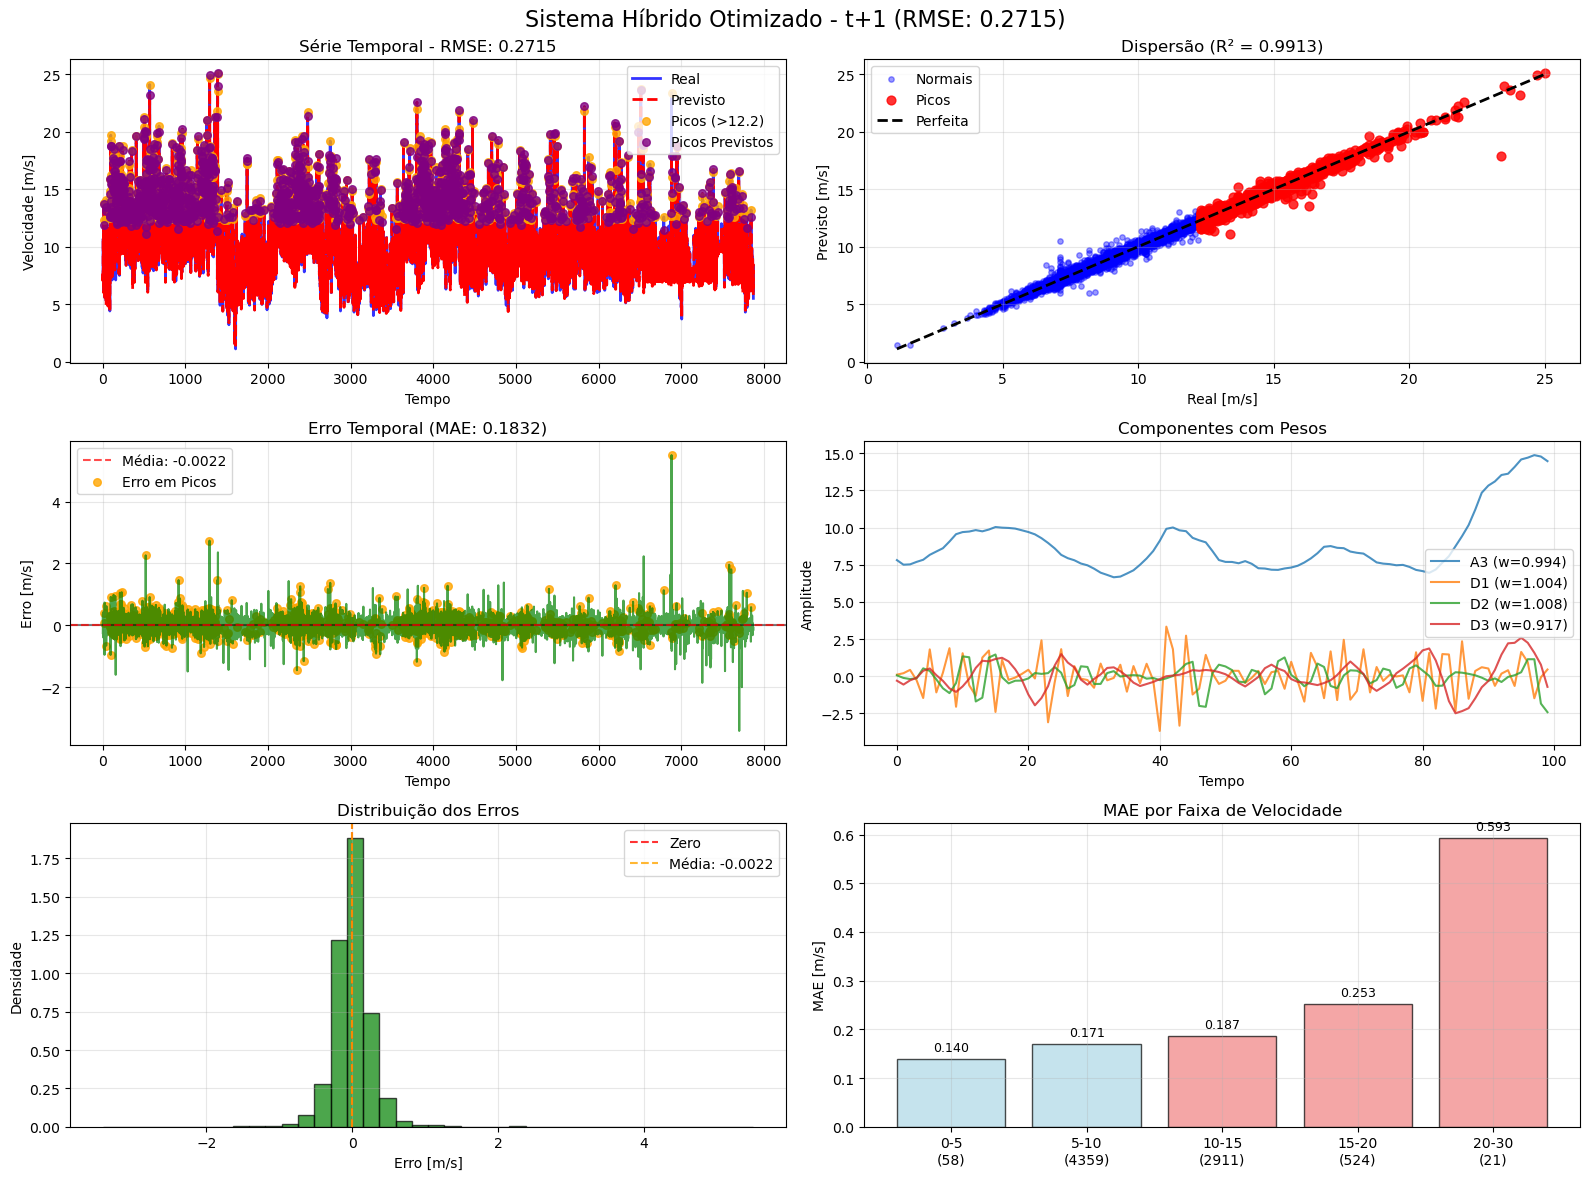


📊 ESTATÍSTICAS DETALHADAS:
   • RMSE: 0.2715
   • MAE:  0.1832
   • MAPE: 1.93%
   • C30:  99.99%
   • R²:   0.9913
   • MAE picos (>12.2): 0.2261
   • MAE normais: 0.1728
   • Número de picos: 1533 (19.5%)


{'RMSE': 0.2715435764793499,
 'MAE': 0.1831777610048261,
 'MAPE': 1.930010822075244,
 'C30': 99.98729836148863,
 'R2': 0.9912544446160748}

In [5]:

visualizar_melhor_sistema(1)